# **Coursework 2**
This coursework for CMT316, done by group number (G4). 


The German Traffic Sign Recognition Benchmark (GTSRB) is a multi-class image classification benchmark in the domain of advanced driver assistance systems and autonomous driving. Naturally, autonomous vehicles must also abide by road legislation and therefore recognize and understand traffic signs. 

Dataset available at https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html 
(German Traffic Sign Recognition Benchmark)

The aim of the project is to **Detection and recognition of traffic signs**


Sections:

###[Packages Installation](#install)
###[Download Train and Test Dataset](#download)
###[Exploratory Data Analysis](#analysis)
###[Preprocessing](#preprocessing)
###[Training - Best Model](#best)
###[Testing](#results)
###[Results](#results)
###[Error Analysis](#errorAnalysis)



<a name='install'></a>
# Packages that has to be installed.

Uncomment the code and execute the cell.

In [ ]:
# Below line is used to install required packages. 
!pip install sklearn Pillow opencv-python tensorflow seaborn pandas numpy matplotlib

     |████████████████████████████████| 462 kB 7.9 MB/s 


In [ ]:
# importing the required modules.
import os
import pathlib
import json
import cv2
from sklearn.utils import shuffle
import csv
import random
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageEnhance
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Declaring the Datsets



Traing Dataset - GTSRB_Final_Training_Images.zip </br>
Test Dataset - GTSRB_Final_Test_Images.zip </br>
Test Dataset Details file - GTSRB_Final_Test_GT.zip </br>
</br>
All Details Provided below


In [ ]:
# URL's for the datasets.

train_dataset_url = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
test_dataset_url = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip"
final_csv = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip"

<a name="download"></a>
# Downloading Training and Testing Datasets

In [ ]:

def data_import(url, directory_name):

    '''
    This function accepts URL and STAGE as input parameters and returns directory path(where zip was extracted).
    '''
    # Downloading zip file from the given URL.
    data_dir = tf.keras.utils.get_file(fname=directory_name,origin=url,extract=True)
    path_list = data_dir.split('/')
    path_list = path_list[:-1]
    path_list.append("GTSRB/" + directory_name + "/Images")
    data_directory = "/".join(path_list)
    print(f"Image Directory path => {data_directory}")


    return data_directory

data_directory = data_import(train_dataset_url, "Final_Training")
test_data_directory = data_import(test_dataset_url, "Final_Test")

276307968/276294756 [==============================] - 21s 0us/step
Image Directory path => /root/.keras/datasets/GTSRB/Final_Training/Images
88989696/88978620 [==============================] - 13s 0us/step
Image Directory path => /root/.keras/datasets/GTSRB/Final_Test/Images


In [ ]:
# Total training images count.
print("Total Training Image Count >> " + str(len(list(pathlib.Path(data_directory).glob('*/*.ppm')))))

# Total testing images count.
print("Total Training Image Count >> " + str(len(list(pathlib.Path(test_data_directory).glob('*.ppm')))))

# Categorize the classes
classes = sorted([ category for category in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, category)) ])
print("Number of categories >>", len(classes))

Total Training Image Count >> 39209
Total Training Image Count >> 12630
Number of categories >> 43


# Prevent Randomization

We are using random seeds to prevent different accuracy scores on multiple execution.

In [ ]:
# used to prevent randomization.
np.random.seed(10)
tf.random.set_seed(20)


# Declaring Constants

In [ ]:
# Defining constants.
IMG_HEIGHT = 32
IMG_WIDTH = 32
CHANNELS = 3
NUM_CATEGORIES = 43


# Reading Train images from directories. 


In [ ]:
# data - contains images present in all directories.
data =[] 
# labels - contains the labels of the images.
labels = []
paths= []

# train_dataframe - This dataframe contains all the info present in the csv files.
train_dataframe = pd.DataFrame();

# Iterating through all categories(folders).
for folder in classes:

    path = os.path.join(data_directory,folder)
    # images - This variable contains all image names present in the folder.
    images = os.listdir(path)
    images = sorted(images)

    # Iterating through all the images.
    for i in images:
        try:
          if ".ppm" in i:
            
            # using PIL library we are reading image.
            image = Image.open(path +'/'+i)                                                         
            image =np.array(image)
            # Appending image
            data.append(image)             
            # Appending label
            labels.append(int(folder))
            paths.append(folder +'/'+i)
          else:
            # If file type is csv this block will be executed.
            temp = pd.read_csv(path+'/'+i,delimiter=";")
            # If the folder contains csv file, we are appending it to training_dataframe
            train_dataframe = train_dataframe.append(temp,ignore_index=True)
        except Exception as e:
            # Ignoring csv
            pass;


In [ ]:
# Adding images list to training dataframe.
train_dataframe["images"] = data

# Displaying first 5 records.
train_dataframe.head()


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,images
0,00000_00000.ppm,29,30,5,6,24,25,0,"[[[75, 78, 80], [74, 76, 78], [86, 87, 84], [1..."
1,00000_00001.ppm,30,30,5,5,25,25,0,"[[[69, 73, 73], [76, 79, 79], [75, 77, 77], [7..."
2,00000_00002.ppm,30,30,5,5,25,25,0,"[[[72, 72, 72], [79, 79, 79], [78, 78, 73], [1..."
3,00000_00003.ppm,31,31,5,5,26,26,0,"[[[68, 67, 67], [76, 72, 73], [90, 82, 82], [1..."
4,00000_00004.ppm,30,32,5,6,25,26,0,"[[[73, 73, 75], [74, 73, 75], [75, 72, 69], [1..."


# Reading Test images from directory.

Testing the model on GTSRB_Final_Test_Images.zip using Details from GTSRB_Final_Test_GT.zip

### Importing Test_GT CSV file

In [ ]:
def test_csv_import(final_csv):
  
    '''
    This fucntion is used to download the test data csv file which has true labels.
    '''
    csv_download = tf.keras.utils.get_file(origin=final_csv,extract=True)
    test_csv_list = csv_download.split('/')[:-1]
    test_csv_list.append('GT-final_test.csv')
    test_csv_directory = "/".join(test_csv_list)
    print(test_csv_directory)
    test_dataframe = pd.read_csv(test_csv_directory,sep=";")
    return test_dataframe

# test_datafram - This variable contains the 
test_dataframe = test_csv_import(final_csv)

# test_images - This variable is a list which contains all the image names.
# classId - This variable is a list which contains the True Category of the images.
test_images,classId = test_dataframe.Filename, test_dataframe.ClassId


114688/99620 [==================================] - 0s 4us/step
/root/.keras/datasets/GT-final_test.csv


### Reading Test Images

In [ ]:
# test_data - This variable contains all the test images data.
test_data = []
test_path = []
class_id = []
for i,j in zip(test_images,classId):
        try:             
            image = Image.open(test_data_directory +'/'+i)                                                              
            image =np.array(image)    
            # print(image)         
            test_data.append(image)          
            test_path.append('/'+i)
            class_id.append(j)
        except Exception as e:
            # Ignoring csv
            # print(e)
            pass;
            # print()

In [ ]:
print(test_images.shape)

(12630,)


In [ ]:
# Addingg test images to dataframe.
test_dataframe["images"] = test_data

# Displaying first 5 rows records in testdataframe.
test_dataframe.head()


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,images
0,00000.ppm,53,54,6,5,48,49,16,"[[[115, 138, 173], [116, 138, 172], [116, 137,..."
1,00001.ppm,42,45,5,5,36,40,1,"[[[55, 69, 61], [82, 82, 65], [91, 78, 61], [9..."
2,00002.ppm,48,52,6,6,43,47,38,"[[[50, 38, 36], [50, 39, 38], [49, 38, 37], [4..."
3,00003.ppm,27,29,5,5,22,24,33,"[[[132, 125, 87], [90, 82, 52], [77, 67, 23], ..."
4,00004.ppm,60,57,5,5,55,52,11,"[[[38, 35, 31], [38, 35, 31], [41, 37, 32], [4..."


# Displaying some random images

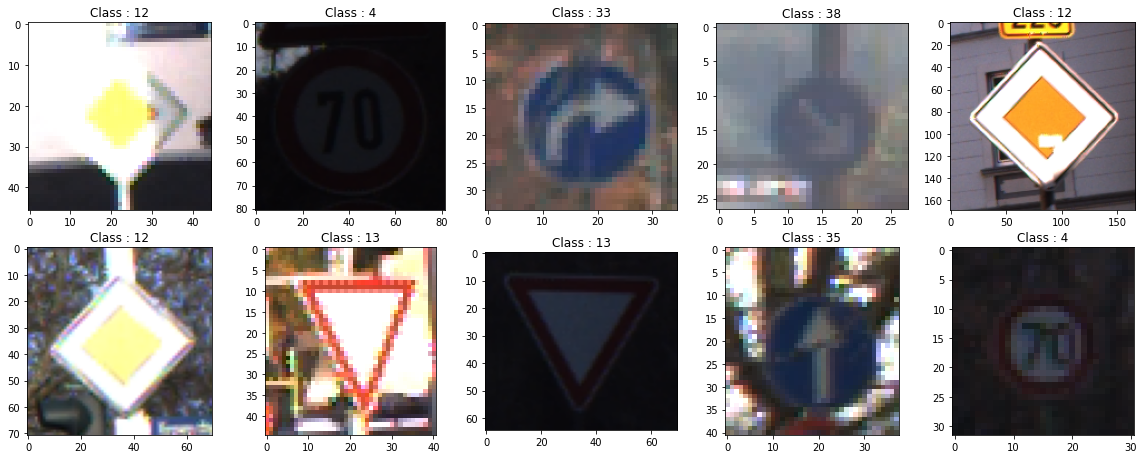

In [ ]:
def display_images(data):
  
  '''
    This function takes list of images as input parameter and displays 10 random images.
  '''
  # Generating 10 random numbers.
  randInt = random.sample(range(len(data)),10)

  # Using matplotlib package to display images.
  fig = plt.figure(figsize=(20, 20))
  for i,id in enumerate(randInt):
    fig.add_subplot(5,5,i+1)
    plt.imshow(data[id])
    # title of the image
    plt.title("Class : "+str(labels[id]))

display_images(data)

<a name="analysis"></a>
# Exploratory Data Analysis 

Observations:

* Data is uneven.

* Looking at the graphs/plots we can say that both train and test data have similar distributions.
* Since all the images have different dimensions, we need to fix the height and width constant for every image to follow.
* We need to perform this in such a way that data loss is least.

* 83% of the images are in range [16-64]px.

* Since the majority of images are in the range of [16-64] px we resize the images to height and width (32, 32).

### Histogram - Training Data


we are using countplot to display the total number of images present in each category.

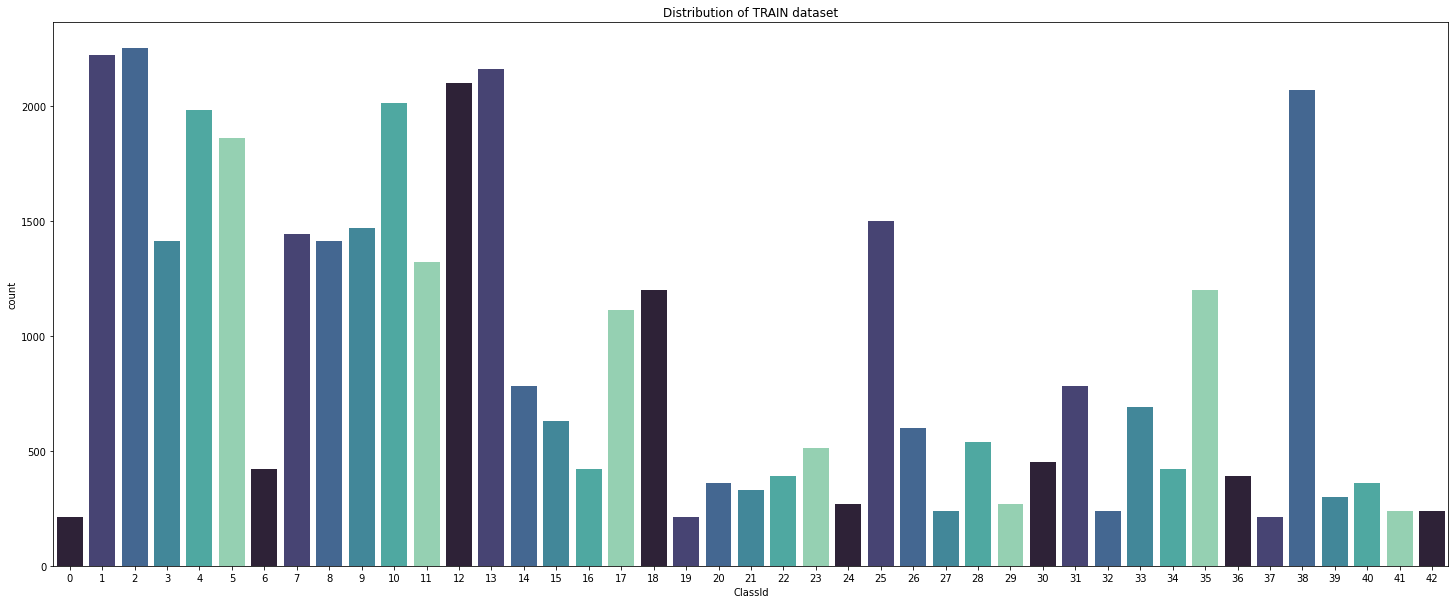

In [ ]:
def visualize(df, stage):

    '''
    This function takes dataframe, stage as the input parameter and show the counts of observations in each categorical bin using bars.
    '''

    # ------------ using seaborn--------------
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches((25,10))
  
    # https://seaborn.pydata.org/tutorial/color_palettes.html
    dis = sns.countplot(data = df, x = 'ClassId' , palette = sns.color_palette("mako"))
    dis.set_title(f"Distribution of {stage} dataset")

# Displaying distributions for TRAIN data.
visualize(train_dataframe, 'TRAIN')

#### Observations:

* The data is uneven and the target classes are clearly not evenly distributed. 

* The distribution of images in each class is uneven. Some classes (such as those with the labels 1, 2, 12, 13, and 38) have over 2000+ images, while others (such as those with the labels 0, 19, 27, 32, 37, 41, and 42) have as few as 250. 
 

### Width Heigth distribution - Training Data

we are using histogram to display width and height distributions

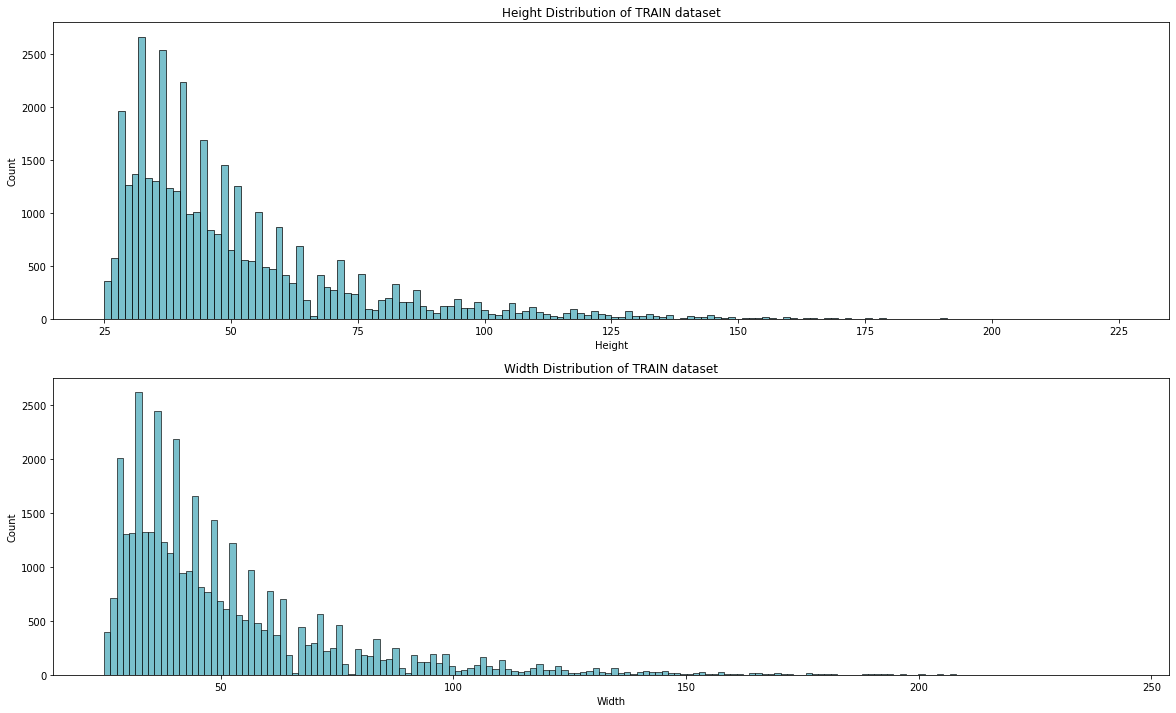

In [ ]:
def wh_distribution(df,stage):
      
    '''
    This fucntion accepts dataframe,stage as input parameter and displays weight and height distribution using histplot.
    '''

    #Distplot for Height and Width of images in train data
    fig, ax = plt.subplots(2)
    fig.set_size_inches((20,12))

    # Using seaborn histogram to display height.
    height = sns.histplot(df['Height'], ax = ax[0] , color = "#4eabbc")
    height.set_title(f"Height Distribution of {stage} dataset")

    fig.set_size_inches((20,12))
    # Using seaborn histogram to display weight.
    width = sns.histplot(df['Width'], ax = ax[1] ,color = "#4eabbc")
    width.set_title(f"Width Distribution of {stage} dataset")


# Displaying width/height using Histogram.
wh_distribution(train_dataframe,"TRAIN")

#### Observations:

* Most image widths range from 25-75px
* Most image heights range from 25-75px

### Pie Plot - Training Data




{'Between 16 and 32': 6812, 'Between 32 and 64': 24842, 'Between 64 and 128': 6193, 'Between 128 and 256': 525}


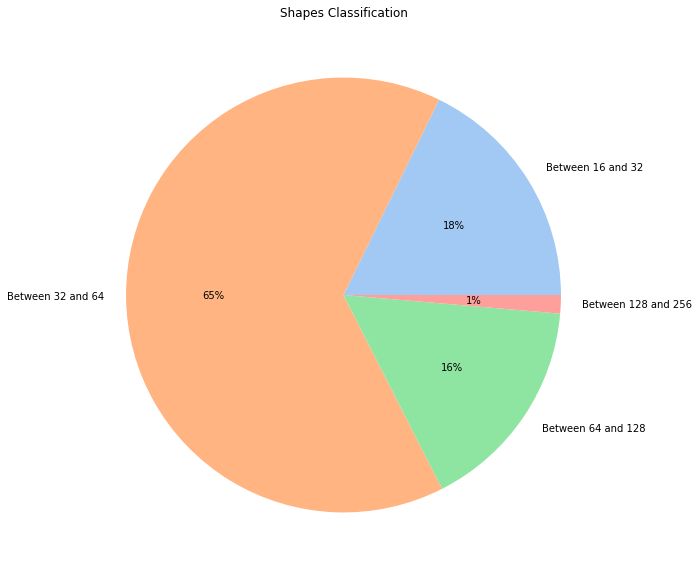

In [ ]:
def pie_plot(df):

  '''
  This function takes dataframe as input and aggregate based on height and width. we are using pie plot to display distributions.
  '''
  d = {
      "Between 16 and 32": 0,
      "Between 32 and 64": 0,
      "Between 64 and 128": 0,
      "Between 128 and 256": 0
  }

  fig = plt.figure(figsize=(20, 20))

  fig.set_size_inches((25,10))
    
  # Iterating through all rows and aggrgating images based on heigth and width.
  for i,item in df.iterrows():
    if item.Width >=16 and item.Height <= 32 and item.Width >=16 and item.Height <= 32:
      d["Between 16 and 32"] +=1;
    elif item.Width >=32 and item.Height <= 64 and item.Width >=32 and item.Height <= 64:
      d["Between 32 and 64"] +=1;
    elif item.Width >=64 and item.Height <= 128 and item.Width >=64 and item.Height <= 128:
      d["Between 64 and 128"] +=1;
    elif item.Width >=128 and item.Height <= 256 and item.Width >=128 and item.Height <= 256:
      d["Between 128 and 256"] +=1;


  print(d)
 
  # using pie plot to display the dictonary.
  plt.pie(d.values(),labels = d.keys(),colors= sns.color_palette("pastel"), autopct='%.0f%%')
  plt.title("Shapes Classification")

  plt.show()


# Displaying width/height distribution using pie plot.
pie_plot(train_dataframe)

#### Observations:

* Almost 83% of the images are in range of 16-64px

### Histogram - Testing Data

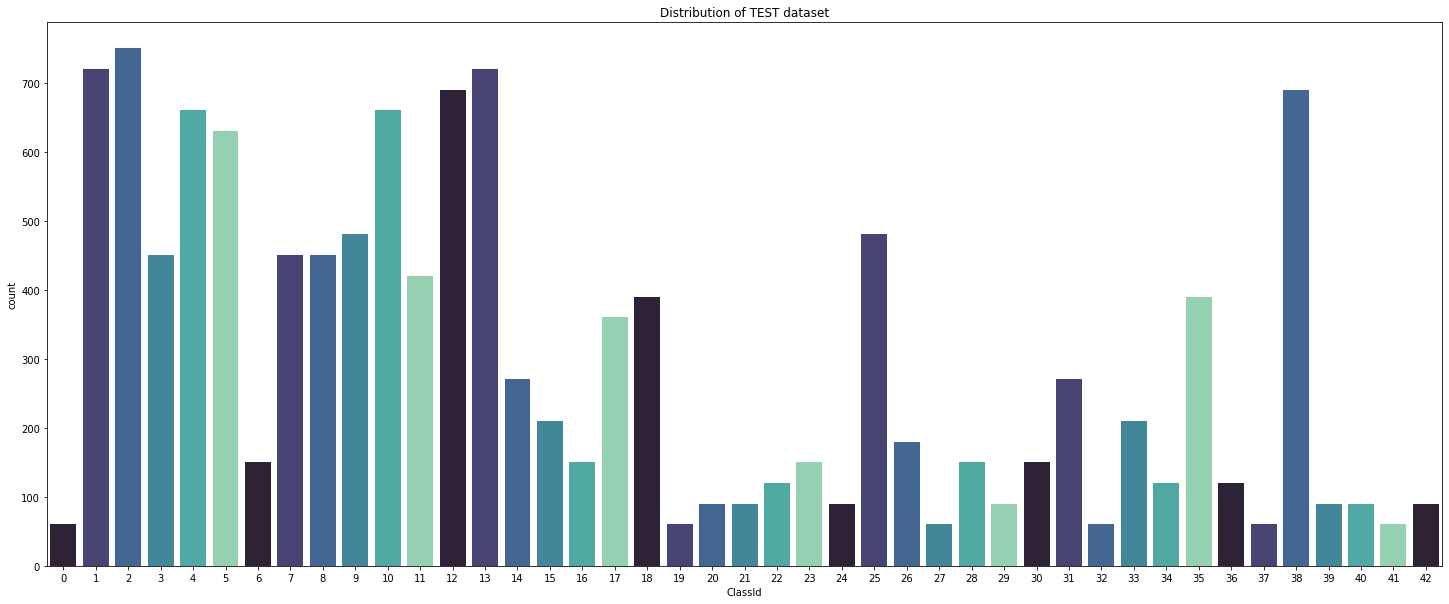

In [ ]:
# Displaying distributions for Test data.
visualize(test_dataframe, 'TEST')


### Width Heigth distribution - Testing Data

we are using histogram to display width and height distributions

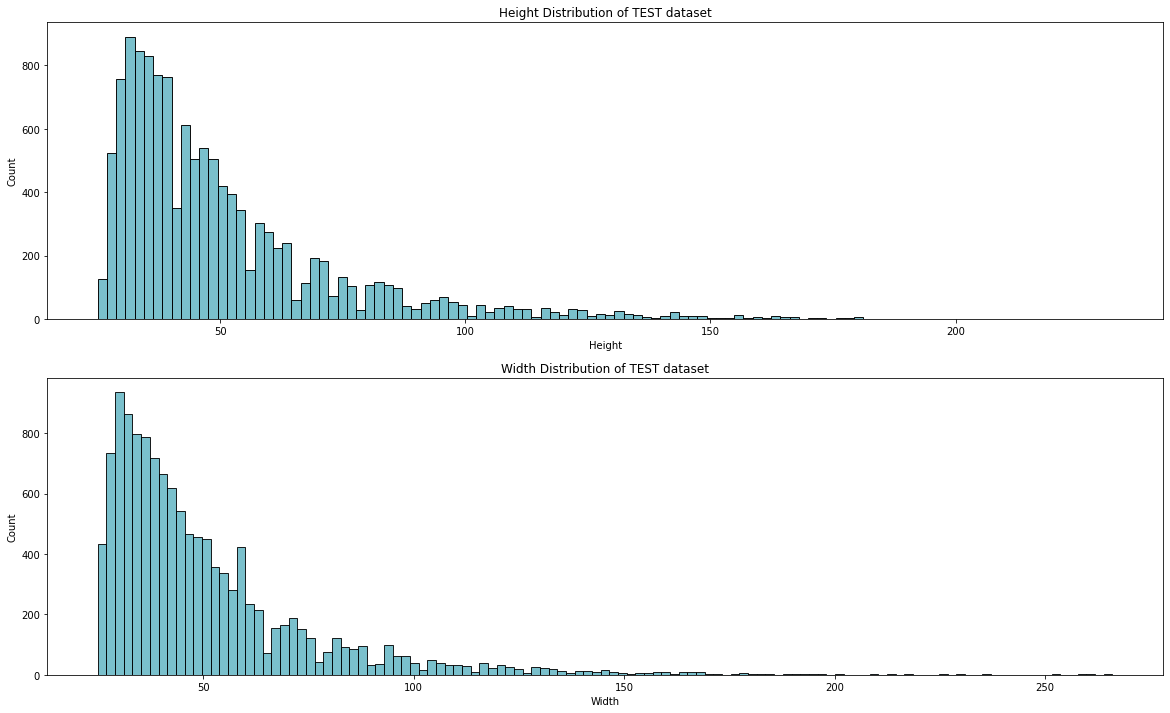

In [ ]:
# Displaying weight/height distribution for test data.
wh_distribution(test_dataframe, 'TEST')


#### Observations:

* Most image widths range from 25-75px
* Most image heights range from 25-75px

### Pie Plot - Testing Data




{'Between 16 and 32': 2298, 'Between 32 and 64': 7809, 'Between 64 and 128': 1917, 'Between 128 and 256': 197}


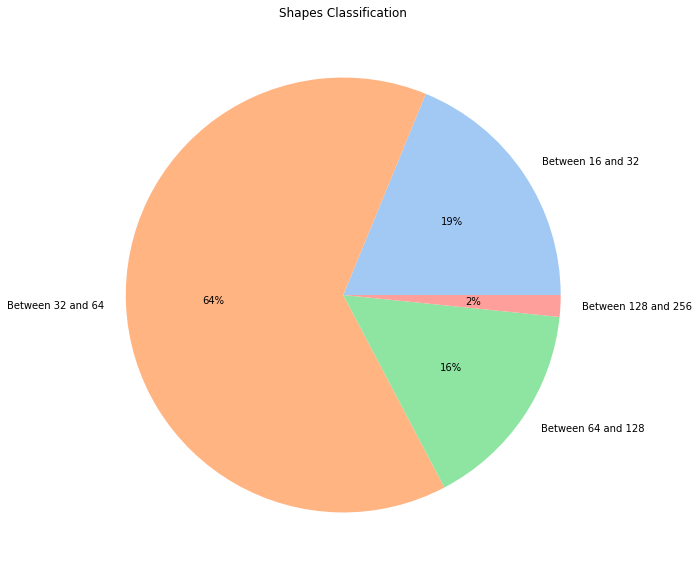

In [ ]:
# Displaying width/height distribution using pie plot for test data.
pie_plot(test_dataframe)


#### Observations:

* Almost 83% of the images are in range of 16-64px

<a name="preprocessing"></a>
# Preprocessing

Step 1: 

*   Step 1: Resizing images to 32x32 shape
*   Step 2: If image is too dark we are increasing brightness of image
*  Step 3: Sharpening Image.
*  Step 4: Normalize image into the range [0-1]




In [ ]:

def preprocessing(images, scaling_sharpen = False):

  '''
  This function takes list of images as input parameter and returns the list of processed images.
  '''
  
  def isDark(image):
    
    '''
    This function takes image as input parameter and returns the quality of image. 
      Ex: returns 'dark'  -> if image is too dark.
          returns 'light' -> if image is moderately dark.
          returns 'good'  -> if image is good. 
    '''

    # Converting it to numpy array.
    image = np.array(image)
    # Blur image.
    blur = cv2.blur(image, (5, 5))
    # Calcuating mean values for RED, GREEN, BLUE layers.
    r,g,b,_ = cv2.mean(blur)

    if r < 22 and b < 22 and g < 22:
      # (r,g,b) < (22,22,22) This implies image is dark. These are experimental values.
      return "dark"
    elif r < 60 and b < 60 and g < 60 :
      # (r,g,b) < (60,60,60) This implies image is moderately dark.
      return "light"
    else:
      # return 'good' if image has good quality.
      return "good"
      
  # processed_images - This variables contains all the list of processed images.
  processed_images = []

  # Iterate through all the images.
  for img in images:

    # Converting to PIL object
    image = Image.fromarray(img)

    # STEP 1 :- Resize image to (32,32)px shape. 
    image = image.resize((IMG_HEIGHT,IMG_WIDTH)) 

    # quality - This variable contians the quality of image.
    quality = isDark(image);

    if  quality == 'dark':
      enhancer = ImageEnhance.Brightness(image)
      # If the image is too dark we are increasing brightness to level 8.
      enhanced_im = enhancer.enhance(8)
    elif quality == 'light':
      enhancer = ImageEnhance.Brightness(image)
      # If the image is moderately dark we are increasing brightness to level 3.
      enhanced_im = enhancer.enhance(3)
    else:
      # If image has good quality we are not increasing brightness.
      enhanced_im = image

    image = np.array(enhanced_im)

    # Added sharpening    
    if scaling_sharpen == False:
      kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
      image = cv2.filter2D(np.array(image), -1, kernel)

    # Normalize the image to range from 0 to 1.
    image = image/255.0

    # Adding processed image to list
    processed_images.append(image)

  return np.array(processed_images)

Tried Other Preprocessing Techniques such as 
1. Grayscaling
2. Local histogram equalization


In [ ]:
# Not utilising this preprocessing function as this did not give any better accuracy 
# compared to that of using the above-mentioned preprocessing funtion

def __preprocessing(images):

  processed_images = []

  for img in images:

    #resizing image
    image = Image.fromarray(img)
    image = image.resize((30,30)) 
    image = np.array(image,dtype=np.uint8)

    #converting colored images into grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #performing local histogram equalization to improve the contrast of the images
    kernel = morp.disk(30)
    img_local = rank.equalize(gray_image, selem=kernel)

    # normalizing the image
    normalized_image = img_local /255.0;

    processed_images.append(normalized_image)

    # Expanding dimentions (30,30) => (30,30,1)
  return np.array(processed_images)[..., None]

# Orginal image Vs Processed Image


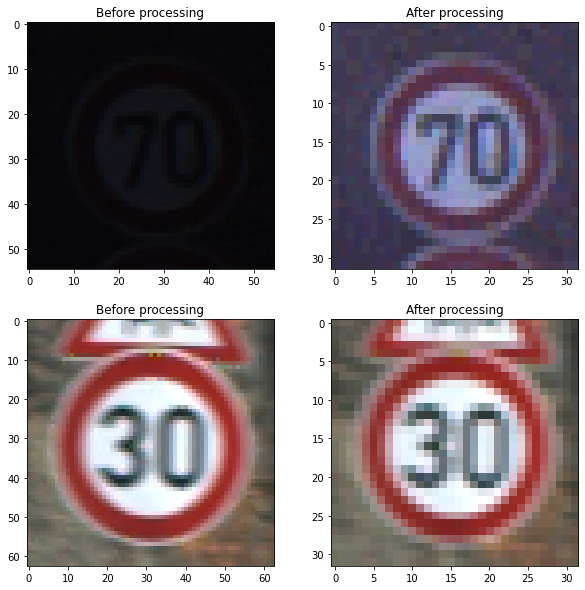

In [ ]:
# Using Matplotlib to display processed images.

height, width = 10, 10
fig, ax = plt.subplots(2,2)
fig.set_size_inches(height, width)

# Picking some random dark image.
image = train_dataframe.iloc[6830].images

# Before preprocessing
ax[0][0].title.set_text('Before processing')
ax[0][0].imshow(image)

# After Preprocessing. since image is dark we are increasing brightness of image.
ax[0][1].title.set_text('After processing')
processed_img  = preprocessing([image],True)[0] 
ax[0][1].imshow(processed_img)

# Picking some good quality image.
image = train_dataframe.iloc[1000].images

# Before preprocessing
ax[1][0].title.set_text('Before processing')
ax[1][0].imshow(image)

# After preprocessing
ax[1][1].title.set_text('After processing')
processed_img  = preprocessing([image],True)[0] 
ax[1][1].imshow(processed_img)

plt.show()

<a name="datasplit"></a>
# Splitting data into train and validation datasets.

We are separating data in the ratio 80:20.

80% - Training Dataset
20% - Validation Dataset


In [ ]:
def data_train_validation_split(data, labels):

    '''
    This function takes images, labels as input and returns 80% train data and 20% validation data.
    '''

    # Spliting the dataset into training and validation 
    train_images, validation_images, train_labels, validation_labels = train_test_split( np.array(data), np.array(labels), test_size=0.2, random_state=0,shuffle=True)

    # Preprocessing images
    train_images = preprocessing(train_images)
    validation_images = preprocessing(validation_images)

    # One hot encoding
    train_labels = keras.utils.to_categorical(train_labels, NUM_CATEGORIES)
    validation_labels = keras.utils.to_categorical(validation_labels, NUM_CATEGORIES)

    return train_images,validation_images,train_labels,validation_labels

# Data split in the ratio 80%:20%
train_images, validation_images, train_labels, validation_labels = data_train_validation_split(data, labels)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


# Model Visualisation  - Function

In [ ]:
# Visualise loss/accuracy during training
def visualiseLossAndAccuracy(his, model):
  
  '''
  This function takes history and model as input parameters and plots the accuracy score.
  '''
  #Plot training & validation accuracy values
  print('\n----------------' + model + '-----------------\n')
  plt.plot(his.history['accuracy']) 
  plt.plot(his.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  #Plot training & validation loss values
  plt.plot(his.history['loss'])
  plt.plot(his.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()



# **Model Creation**

We have created **8 models** in total
1. Six models are used to do comparasions for 6 different hyper parameters:
  - **Model#1 and Model#2 :** To compare Relu activation function with Leeky Relu activation function.
  - **Model#3 and Model#4 :** To compare a model with Augmentation or without Augmentation. 
  - **Model#5 and Model#6 :** To compare a model with Dorpout or without Dropout.

2. **A Combined model:** created based on the best hyper prameters.

3. **A Final model:** created based on more enhancments on the Combined model (BachNormalization Layers).

# Model 1: Basic Model with "ReLu" Activation function

Activation Funtion : Relu

No augmentation

15 epochs


In [ ]:

def create_model():
    ##Basic CNN network
    model = models.Sequential()
    #Image size is 32,32,3 -> we are reshaping image 
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

    #The Below layers can be experimental
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    #The output layer should be of 43 size to match the number of classes 
    model.add(layers.Dense(43,activation='softmax'))
    #model.summary()

    #Choose the optimizer type and how to measure the performance 
    # model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model_basic = create_model()

model_basic.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

### Model 1 - Training

In [ ]:
history_basic =  model_basic.fit(train_images, train_labels, batch_size=16, epochs=15,validation_data=(validation_images, validation_labels))

Epoch 1/15
1961/1961 [==============================] - 19s 4ms/step - loss: 0.6028 - accuracy: 0.8325 - val_loss: 0.1592 - val_accuracy: 0.9551
Epoch 2/15
1961/1961 [==============================] - 8s 4ms/step - loss: 0.0956 - accuracy: 0.9713 - val_loss: 0.0752 - val_accuracy: 0.9836
Epoch 3/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.0832 - val_accuracy: 0.9769
Epoch 4/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0417 - accuracy: 0.9867 - val_loss: 0.0917 - val_accuracy: 0.9750
Epoch 5/15
1961/1961 [==============================] - 9s 5ms/step - loss: 0.0320 - accuracy: 0.9896 - val_loss: 0.0909 - val_accuracy: 0.9782
Epoch 6/15
1961/1961 [==============================] - 8s 4ms/step - loss: 0.0244 - accuracy: 0.9926 - val_loss: 0.0900 - val_accuracy: 0.9850
Epoch 7/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.0872 - val_accuracy

### Model 1 - Visualisations


----------------Basic Model-----------------



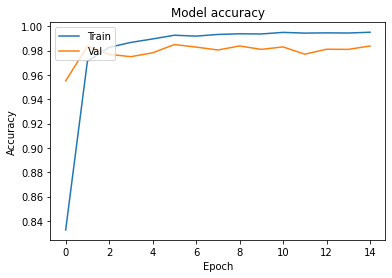

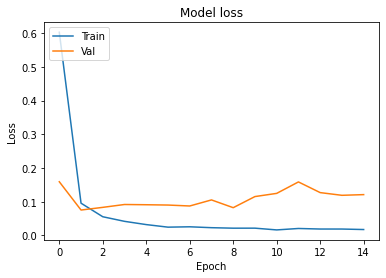

In [ ]:
visualiseLossAndAccuracy(history_basic,"Basic Model")

2. Training CNN model with additional MaxPooling2D layer to the previous model and do **comparasion between Relu and LeekyRelu** Activation functions 

# Model 2: Basic Model with "Leeky Relu" Activation function

Activation Funtion : Leeky Relu

No augmentation

15 epochs


In [ ]:

def create_model_leekyrelu():
    ##Basic CNN network
    model = models.Sequential()
    #Image size is 32,32,3 -> we are reshaping image 
    model.add(layers.Conv2D(32, (3, 3), activation='LeakyReLU', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

    #The Below layers can be experimental
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='LeakyReLU'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='LeakyReLU'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='LeakyReLU'))

    #The output layer should be of 43 size to match the number of classes 
    model.add(layers.Dense(43,activation='softmax'))
    #model.summary()

    #Choose the optimizer type and how to measure the performance 
    # model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model_LeekyRelu = create_model_leekyrelu()

model_LeekyRelu.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 64)        

### Model 2 - Training


In [ ]:
history_LeekyRelu = model_LeekyRelu.fit(train_images, train_labels, batch_size=16, epochs=15,validation_data=(validation_images, validation_labels))

Epoch 1/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.4858 - accuracy: 0.8641 - val_loss: 0.0898 - val_accuracy: 0.9736
Epoch 2/15
1961/1961 [==============================] - 10s 5ms/step - loss: 0.0587 - accuracy: 0.9824 - val_loss: 0.0655 - val_accuracy: 0.9820
Epoch 3/15
1961/1961 [==============================] - 8s 4ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0738 - val_accuracy: 0.9793
Epoch 4/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0321 - accuracy: 0.9902 - val_loss: 0.0599 - val_accuracy: 0.9862
Epoch 5/15
1961/1961 [==============================] - 8s 4ms/step - loss: 0.0263 - accuracy: 0.9924 - val_loss: 0.0785 - val_accuracy: 0.9819
Epoch 6/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0253 - accuracy: 0.9932 - val_loss: 0.1405 - val_accuracy: 0.9764
Epoch 7/15
1961/1961 [==============================] - 8s 4ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0704 - val_accuracy

### Model 2  - Visualisation


----------------Leeky Relu-----------------



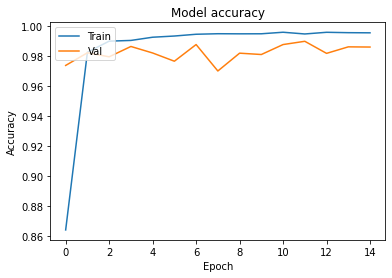

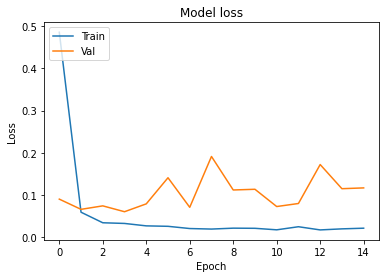

In [ ]:
visualiseLossAndAccuracy(history_LeekyRelu, "Leeky Relu")

#Model 3 : With Augmentation



In [ ]:

def create_mode():
    ##Basic CNN network
    model = models.Sequential()
    #Image size is 32,32,3 -> we are reshaping image 
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

    #The Below layers can be experimental
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    #The output layer should be of 43 size to match the number of classes 
    model.add(layers.Dense(43,activation='softmax'))
    #model.summary()

    #Choose the optimizer type and how to measure the performance 
    # model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model_with_aug = create_model()

model_with_aug.summary()



# modelArray.fit()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

### Augmentation


In [ ]:
#Some additional arguments and parameters are specified to enhance the performance 
def aug_matrix(): 
    aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
        
    return aug

aug = aug_matrix()

### Model 3 - Training

In [ ]:
history_with_aug = model_with_aug.fit(aug.flow(train_images, train_labels), batch_size=16, epochs=15,validation_data=(validation_images, validation_labels))

Epoch 1/15
981/981 [==============================] - 19s 18ms/step - loss: 1.5605 - accuracy: 0.5418 - val_loss: 0.4635 - val_accuracy: 0.8471
Epoch 2/15
981/981 [==============================] - 18s 18ms/step - loss: 0.5499 - accuracy: 0.8228 - val_loss: 0.2462 - val_accuracy: 0.9220
Epoch 3/15
981/981 [==============================] - 18s 18ms/step - loss: 0.3458 - accuracy: 0.8899 - val_loss: 0.1604 - val_accuracy: 0.9463
Epoch 4/15
981/981 [==============================] - 18s 18ms/step - loss: 0.2540 - accuracy: 0.9206 - val_loss: 0.1393 - val_accuracy: 0.9572
Epoch 5/15
981/981 [==============================] - 18s 19ms/step - loss: 0.1959 - accuracy: 0.9369 - val_loss: 0.1027 - val_accuracy: 0.9693
Epoch 6/15
981/981 [==============================] - 18s 18ms/step - loss: 0.1676 - accuracy: 0.9459 - val_loss: 0.0905 - val_accuracy: 0.9725
Epoch 7/15
981/981 [==============================] - 18s 18ms/step - loss: 0.1452 - accuracy: 0.9540 - val_loss: 0.0656 - val_accuracy:

### Model 3 : Visualisation


----------------With Augmentation-----------------



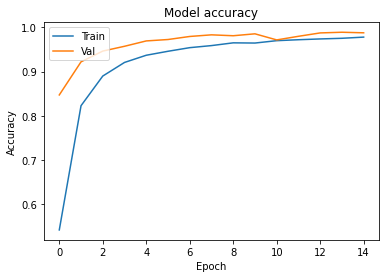

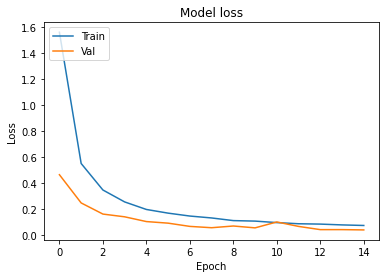

In [ ]:
visualiseLossAndAccuracy(history_with_aug,"With Augmentation")

# Model 4 - Without Augmentation

In [ ]:

def create_mode():
    ##Basic CNN network
    model = models.Sequential()
    #Image size is 32,32,3 -> we are reshaping image 
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

    #The Below layers can be experimental
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    #The output layer should be of 43 size to match the number of classes 
    model.add(layers.Dense(43,activation='softmax'))
    #model.summary()

    #Choose the optimizer type and how to measure the performance 
    # model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model_no_aug = create_model()

model_no_aug.summary()



# modelArray.fit()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 1024)             

### Model 4 - Training

In [ ]:
history_no_aug = model_no_aug.fit(train_images, train_labels, batch_size=16, epochs=15,validation_data=(validation_images, validation_labels))

Epoch 1/15
1961/1961 [==============================] - 9s 5ms/step - loss: 0.5803 - accuracy: 0.8424 - val_loss: 0.1251 - val_accuracy: 0.9686
Epoch 2/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0806 - accuracy: 0.9766 - val_loss: 0.0991 - val_accuracy: 0.9728
Epoch 3/15
1961/1961 [==============================] - 8s 4ms/step - loss: 0.0496 - accuracy: 0.9854 - val_loss: 0.0843 - val_accuracy: 0.9773
Epoch 4/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0367 - accuracy: 0.9880 - val_loss: 0.1037 - val_accuracy: 0.9744
Epoch 5/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0296 - accuracy: 0.9916 - val_loss: 0.0858 - val_accuracy: 0.9820
Epoch 6/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0268 - accuracy: 0.9914 - val_loss: 0.0764 - val_accuracy: 0.9825
Epoch 7/15
1961/1961 [==============================] - 9s 4ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.0704 - val_accuracy:

### Model 4 - Visualization


----------------Model without Augmentaiton-----------------



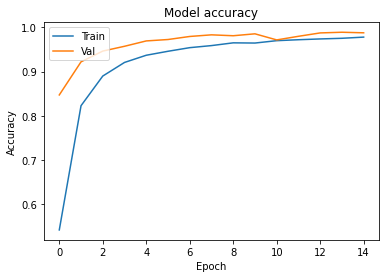

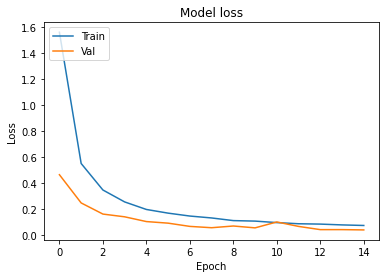

In [ ]:
visualiseLossAndAccuracy(history_with_aug,"Model without Augmentaiton")

# Model 5 - With Dropout

In [ ]:

#Model With Dropout 
def create_model_with_dropout():
    ##Basic CNN network
    model = models.Sequential()
    #Image size is 32,32,3 -> we are reshaping image 
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

    #The Below layers can be experimental
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.5))
    #The output layer should be of 43 size to match the number of classes 
    model.add(layers.Dense(43,activation='softmax'))
    #model.summary()

    #Choose the optimizer type and how to measure the performance 
    # model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model_with_dropout = create_model_with_dropout()

model_with_dropout.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 3, 128)        

### Augmentation


In [ ]:
#Some additional arguments and parameters are specified to enhance the performance 
def aug_matrix(): 
    aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
        
    return aug

aug = aug_matrix()

### Model 5 - Training

In [ ]:
history_with_dropout = model_with_dropout.fit(aug.flow(train_images, train_labels), batch_size=16, epochs=15,validation_data=(validation_images, validation_labels))

Epoch 1/15
981/981 [==============================] - 22s 21ms/step - loss: 2.4147 - accuracy: 0.2866 - val_loss: 1.2904 - val_accuracy: 0.5296
Epoch 2/15
981/981 [==============================] - 19s 20ms/step - loss: 1.2037 - accuracy: 0.5767 - val_loss: 0.6423 - val_accuracy: 0.7697
Epoch 3/15
981/981 [==============================] - 20s 21ms/step - loss: 0.7531 - accuracy: 0.7394 - val_loss: 0.3693 - val_accuracy: 0.8679
Epoch 4/15
981/981 [==============================] - 19s 20ms/step - loss: 0.5561 - accuracy: 0.8070 - val_loss: 0.2857 - val_accuracy: 0.8883
Epoch 5/15
981/981 [==============================] - 19s 19ms/step - loss: 0.4353 - accuracy: 0.8487 - val_loss: 0.2170 - val_accuracy: 0.9239
Epoch 6/15
981/981 [==============================] - 19s 20ms/step - loss: 0.3686 - accuracy: 0.8780 - val_loss: 0.1371 - val_accuracy: 0.9554
Epoch 7/15
981/981 [==============================] - 19s 20ms/step - loss: 0.2946 - accuracy: 0.9063 - val_loss: 0.0920 - val_accuracy:

### Model 5 : Visualisation


----------------Model with Dropout-----------------



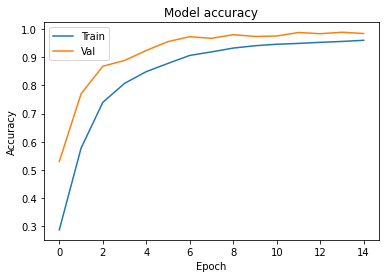

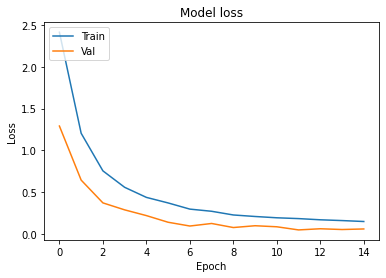

In [ ]:
visualiseLossAndAccuracy(history_with_dropout,"Model with Dropout")

# Model 6: Without Dropout

In [ ]:

#Model Without Dropout 
def create_model_without_dropout():
    ##Basic CNN network
    model = models.Sequential()
    #Image size is 32,32,3 -> we are reshaping image 
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

    #The Below layers can be experimental
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation="relu"))
    #The output layer should be of 43 size to match the number of classes 
    model.add(layers.Dense(43,activation='softmax'))
    #model.summary()

    #Choose the optimizer type and how to measure the performance 
    # model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model_without_dropout = create_model_without_dropout()

model_without_dropout.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 3, 3, 128)        

### Augmentation


In [ ]:
#Some additional arguments and parameters are specified to enhance the performance 
def aug_matrix(): 
    aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
        
    return aug

aug = aug_matrix()

### Model 6 - Training

In [ ]:
history_without_dropout = model_without_dropout.fit(aug.flow(train_images, train_labels), batch_size=16, epochs=15,validation_data=(validation_images, validation_labels))

Epoch 1/15
981/981 [==============================] - 19s 19ms/step - loss: 1.5255 - accuracy: 0.5332 - val_loss: 0.3413 - val_accuracy: 0.8836
Epoch 2/15
981/981 [==============================] - 18s 18ms/step - loss: 0.3214 - accuracy: 0.8953 - val_loss: 0.1506 - val_accuracy: 0.9522
Epoch 3/15
981/981 [==============================] - 18s 18ms/step - loss: 0.1816 - accuracy: 0.9417 - val_loss: 0.0577 - val_accuracy: 0.9825
Epoch 4/15
981/981 [==============================] - 18s 19ms/step - loss: 0.1267 - accuracy: 0.9601 - val_loss: 0.0787 - val_accuracy: 0.9759
Epoch 5/15
981/981 [==============================] - 18s 19ms/step - loss: 0.1077 - accuracy: 0.9662 - val_loss: 0.0464 - val_accuracy: 0.9872
Epoch 6/15
981/981 [==============================] - 18s 18ms/step - loss: 0.0948 - accuracy: 0.9705 - val_loss: 0.0336 - val_accuracy: 0.9908
Epoch 7/15
981/981 [==============================] - 18s 19ms/step - loss: 0.0802 - accuracy: 0.9762 - val_loss: 0.0723 - val_accuracy:

### Model 6 : Visualisation


----------------Model Without Dropout-----------------



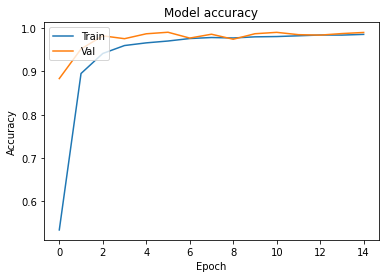

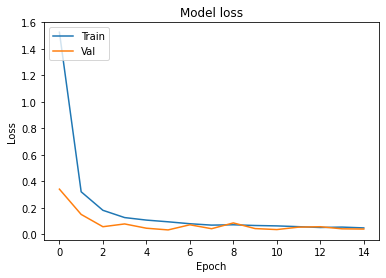

In [ ]:
visualiseLossAndAccuracy(history_without_dropout,"Model Without Dropout")

# Combined Model

In [ ]:
# Early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#Model With LeakyRelu - Augmentaion - Dropout 

# Basic CNN network
finalmodel = models.Sequential()
#Image size is 32,32,3 -> we are reshaping image 
finalmodel.add(layers.Conv2D(32, (3, 3), activation='LeakyReLU', input_shape=(32, 32, 3)))

#The Below layers can be experimental
finalmodel.add(layers.MaxPooling2D((2, 2)))
finalmodel.add(layers.Conv2D(64, (3, 3), activation='LeakyReLU'))
finalmodel.add(layers.Conv2D(64, (3, 3), activation='LeakyReLU'))
finalmodel.add(layers.MaxPooling2D((2, 2)))
finalmodel.add(layers.Conv2D(128, (3, 3), activation='LeakyReLU'))
finalmodel.add(layers.Conv2D(128, (3, 3), activation='LeakyReLU'))
    
finalmodel.add(layers.Flatten())
finalmodel.add(layers.Dense(128, activation='LeakyReLU'))
finalmodel.add(layers.Dense(64, activation="LeakyReLU"))
#The output layer should be of 43 size to match the number of classes 
finalmodel.add(layers.Dense(43,activation='softmax'))
finalmodel.summary()

#Choose the optimizer type and how to measure the performance 
finalmodel.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
#  history = modelObject["model"].fit(modelObject["train_data"],batch_size=modelObject["batch_size"], epochs= modelObject["epochs"],validation_data=modelObject["validation_data"])  
final_model_history = finalmodel.fit(aug.flow(train_images,train_labels), batch_size = 16, epochs = 60, validation_data=(validation_images,validation_labels), callbacks=[early_stopping_cb])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 conv2d_24 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 3, 3, 128)        

<a name="best"></a>
# Final Model - Best

* Conv2d Layer
* Maxpool2D
* BatchNormalization
* LeakyRelu Activation function.
* Dropout
* Augmentation
* 30 epoch


In [ ]:
final_model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='LeakyReLU', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='LeakyReLU'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='LeakyReLU'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='LeakyReLU'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='LeakyReLU'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

# Displaying model summary.
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)      

### Augmentation

In [ ]:
# Creating a augmentation object.
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")


### Final Model Training

In [ ]:
# Learning rate.
lr = 0.001

# Epoch number
epochs = 30

# Creating adam optmizer.
opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))

# Compiling model object.
final_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training the model.
final_history = final_model.fit(aug.flow(train_images, train_labels, batch_size=32), epochs=30, validation_data=(validation_images, validation_labels))


Epoch 1/30
981/981 [==============================] - 46s 34ms/step - loss: 0.8533 - accuracy: 0.7610 - val_loss: 0.1005 - val_accuracy: 0.9699
Epoch 2/30
981/981 [==============================] - 34s 35ms/step - loss: 0.2375 - accuracy: 0.9284 - val_loss: 0.0628 - val_accuracy: 0.9816
Epoch 3/30
981/981 [==============================] - 32s 33ms/step - loss: 0.1574 - accuracy: 0.9506 - val_loss: 0.0387 - val_accuracy: 0.9884
Epoch 4/30
981/981 [==============================] - 32s 33ms/step - loss: 0.1203 - accuracy: 0.9628 - val_loss: 0.0478 - val_accuracy: 0.9860
Epoch 5/30
981/981 [==============================] - 34s 34ms/step - loss: 0.1026 - accuracy: 0.9679 - val_loss: 0.0306 - val_accuracy: 0.9906
Epoch 6/30
981/981 [==============================] - 34s 34ms/step - loss: 0.0870 - accuracy: 0.9721 - val_loss: 0.0320 - val_accuracy: 0.9907
Epoch 7/30
981/981 [==============================] - 32s 33ms/step - loss: 0.0782 - accuracy: 0.9755 - val_loss: 0.0296 - val_accuracy:


----------------Best Model-----------------



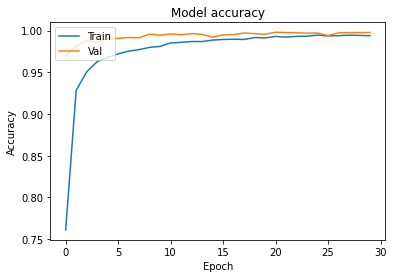

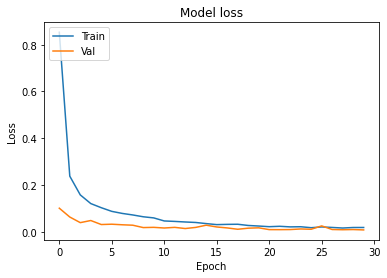

In [ ]:
# Display the accuracy score for the model.
visualiseLossAndAccuracy(final_history, "Best Model")

# Preprocessing Test images

In [ ]:
# Preprocessing Test Data
test_images = preprocessing(np.array(test_data))

## Gold Data
test_gold = class_id

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


<a name="results"></a>
# Predicting Test Images
 

In [ ]:
def print_metrics(Y_pred, Y_true, stage):

    '''
    This fucntion prints the metrics of the model. It also shows confusion matrix.
    '''
    print('----------------------' + stage + '-----------------------')
    
    score = accuracy_score(Y_true,Y_pred) * 100
    print('accuracy = ', round(score, 3))

    precision = precision_score(Y_true, Y_pred, average='weighted', zero_division=0) * 100
    recall = recall_score(Y_true,Y_pred, average='weighted', labels=np.unique(Y_pred), zero_division=0) * 100
    f1 = f1_score(Y_true,Y_pred, average='weighted', labels=np.unique(Y_pred)) * 100

    print("precision = ", round(precision,3))
    print("recall = ", round(recall,3))
    print("f1 score = ", round(f1,3))
    print('            ------Confusion Matrix ------                 ')
    print(confusion_matrix(Y_true, Y_pred))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_true, Y_pred),  display_labels=range(43))    
    fig, ax = plt.subplots(figsize=(20,20))
    disp = disp.plot(include_values=True,ax=ax)
    plt.show()
    print('----------------------' + stage + '-----------------------')
    print('   ')

----------------------TEST-----------------------
accuracy =  98.591
precision =  98.612
recall =  98.591
f1 score =  98.581
            ------Confusion Matrix ------                 
[[ 60   0   0 ...   0   0   0]
 [  0 719   0 ...   0   0   0]
 [  0   0 746 ...   0   0   0]
 ...
 [  0   0   0 ...  88   0   0]
 [  0   0   0 ...   0  60   0]
 [  0   0   0 ...   0   0  90]]


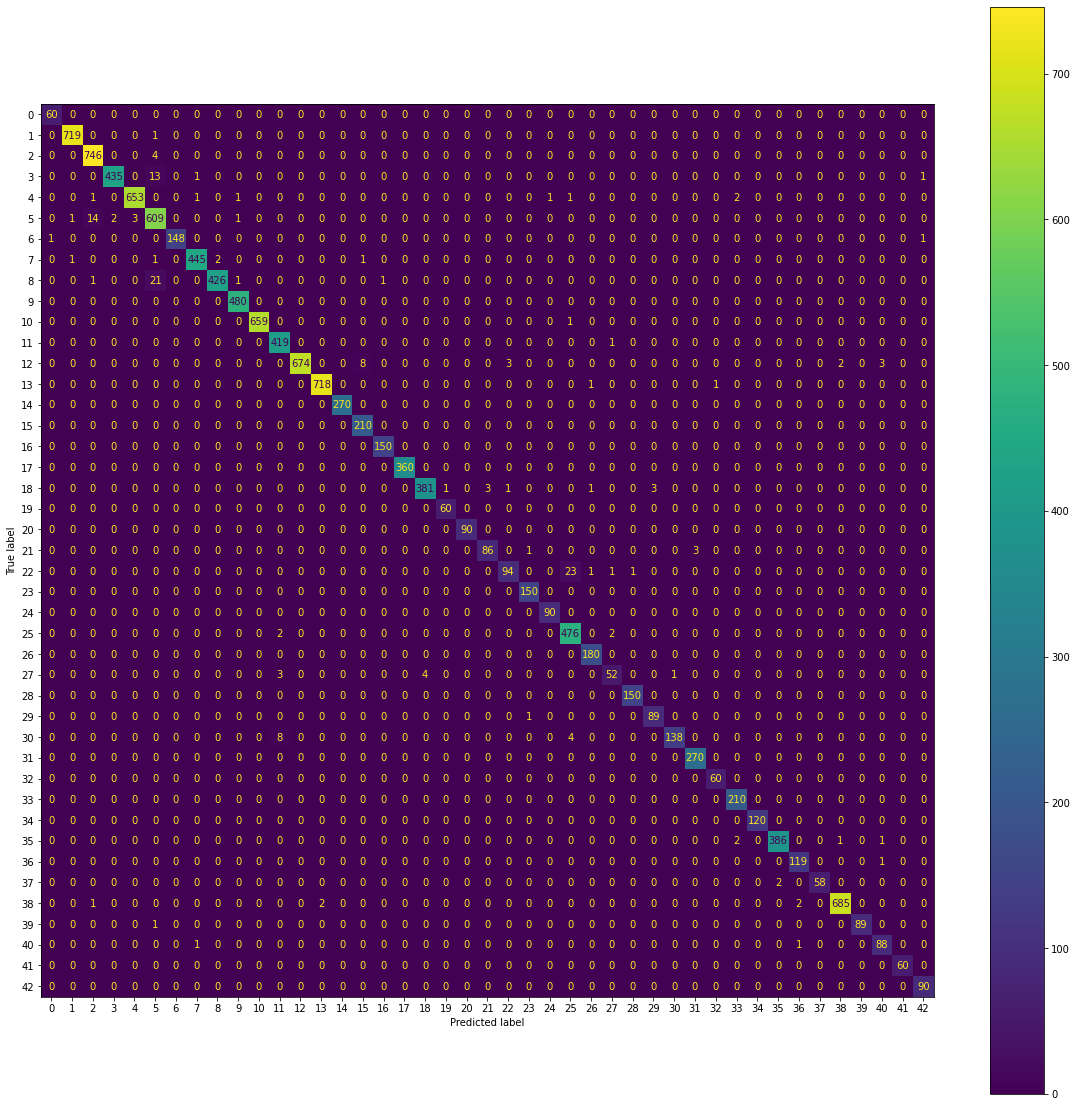

----------------------TEST-----------------------
   


In [ ]:

# Predicting the test data.
predicted =[np.argmax(value) for value in final_model.predict(test_images)]

# Printing all metrics.
print_metrics(predicted,test_gold,"TEST")


Observations:

Looking at the confusion matrix we noticed that category 22 and 8 images have highest number of misclassifications.

<a name='errorAnalysis'></a>
# Error Analysis

Displayiing first 40 failed images



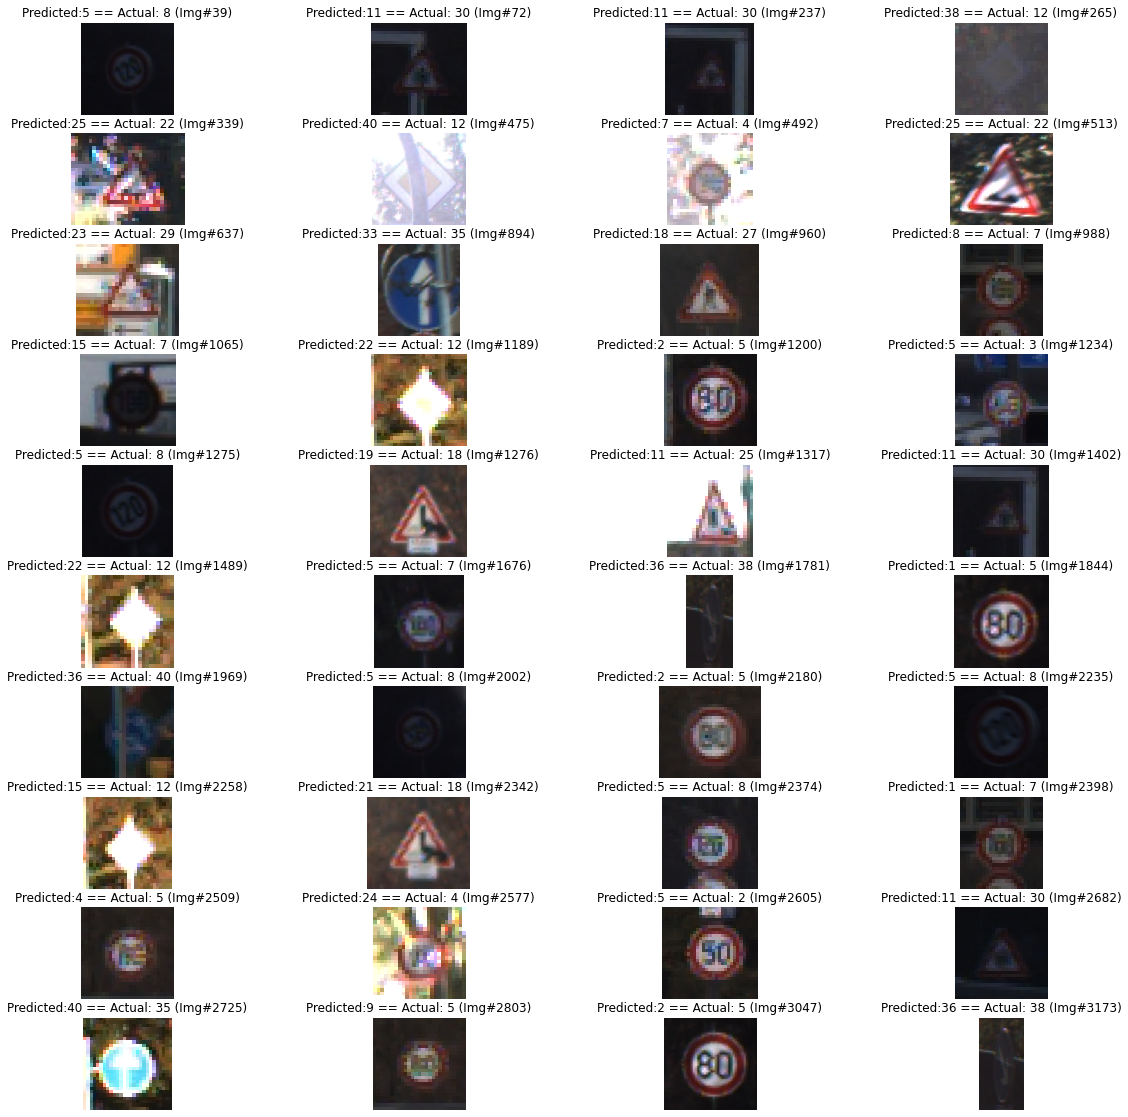

In [ ]:
# Creating dataframe for falied predictions.
failed_cases = test_dataframe[test_gold != np.array(predicted)]


fig = plt.figure(figsize=(20, 20))

x = 0

#for i,index in enumerate(failed_cases[failed_cases.ClassId ==18].index[:30]):

# Iterating through the failed dataframe and displaying images with actual and predicted category.
for i,index in enumerate(failed_cases.index[:40]):
    fig.add_subplot(10,4,i+1)
    plt.imshow(failed_cases.loc[index].images)
    plt.axis('off')
    plt.title(f"Predicted:{predicted[index]} == Actual: {test_gold[index]} (Img#{index})")
    plt.xlabel(f"Img#{index}")

    # plt.show()

In [ ]:
from collections import defaultdict


# Creating dictonary for the misclassification categories.

failed_dict = defaultdict(int)

for i in range(len(predicted)):
    if(test_gold[i] != predicted[i]):
      failed_dict[test_gold[i]] += 1

# Sorting
d = dict(sorted(failed_dict.items(), key=lambda item: item[1],reverse = True))

print("Number of Images that our model failed to predict with respect to class ",sum(d.values()))

# Displaying the misclassifications.
for k,v in d.items():
  print(f"{k} : {v}")




Number of Images that our model failed to predict with respect to class  178
22 : 26
8 : 24
5 : 21
12 : 16
3 : 15
30 : 12
18 : 9
27 : 8
4 : 7
7 : 5
38 : 5
35 : 4
25 : 4
2 : 4
21 : 4
40 : 2
37 : 2
13 : 2
6 : 2
29 : 1
39 : 1
10 : 1
11 : 1
36 : 1
1 : 1


Observations:

* Category 22 images have 26 misclassifications.
* Category 8 images have 24 miscalssifications.
* More info can be found in confusion matrix.